# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 19.04.2023  
**Due date:** 05.05.2023 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

--
## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In this lab, we will use PyTorch. If you are not familiar with this library, [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a quick tutorial of the basics.

In [2]:
import platform
print(platform.system())
if platform.system() == "Darwin":
    %pip install torch==1.8.1 torchvision==0.9.1
else:
    %pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Windows
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1 - Out-of-Distribution detection in colorectal cancer histology (12 points)

Colorectal cancer is one of the most widespread cancers for men and women. Diagnosis complemented with prognostic and predictive biomarker information is essential for patient monitoring and applying personalized treatments. A critical marker is the tumor/stroma ratio in unhealthy tissues sampled from the colon. The higher the ratio, the more invasive the cancer is. The degree of invasion is tightly linked to patient survial probability.

To measure the ratio, a pathologist needs to analyze the unhealthy tissue under a microscope and estimate it from a look. As the number of samples to analyze is huge and estimations are only sometimes precise, automatic recognition of the different tissue types in histological images has become essential. Such an automatic process requires the development of a multi-class classifier to identify the numerous tissues. As shown below, they are usually 8 tissue types to categorize: TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE and EMPTY (background).

<br />
<br />
<figure>
    <img src="../data/lab-03-data/part1/kather16.svg" width="1100">
    <center>
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology (Kather-16)</figcaption>
    </center>
</figure>
<br />
<br />


Up to this day, state-of-the-art methods use deep-learning-based supervised learning methods. A downfall of such an approach is the necessity to access a well-annotated training dataset. In histology, annotating data is difficult. It is time-consuming and requires the expertise of pathologists. Moreover, the annotator must label every tissue type while only two (TUMOR and STROMA) are interesting. 


Consequently, we propose another approach. In order to make the annotation task less tedious, we ask the annotator to label only the tissues of interest and dump the others. Then, we must train a binary classifier to automatically recognize these tissues at test time. In this part, you will implement the proposed approach.

### 1.1 Binary classifier with Mahalanobis distance (3 points)

Based on the abovementioned process, your task is to build a model that recognizes TUMOR (Label 0) and STROMA (Label 1) tissue types. Your model will be supervised by a training dataset containing TUMOR and STROMA annotations; note that all other tissues have been dropped.
We will not ask you to train a deep-learning-based binary classifier from scratch. Instead, we provide excellent features (descriptors) of the images we extracted from a visual foundation model. (Note: As the nature of the foundation model is not part of this lecture, feel free to ask TAs if you are curious).

Run the cell below to extract the provided train and test dataset. Each image is represented by a 768-d feature vector extracted from a visual foundation model. The train and test datasets contain feature vectors of 878 and 186 images respectively.

In [4]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

**Task 1 (2.5 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using minimum Mahalanobis distance.

*Note:* You are not allowed to use any prebuilt Mahalanobis distance function. Additionally, ```torch.cov``` is not defined to compute the covariance matrix. You can use ```sklearn.covariance.LedoitWolf``` instead.

In [5]:
### Task 1
### YOUR CODE
import sklearn
import sklearn.covariance
import numpy as np
import matplotlib.pyplot as plt

# First step : calculate the mean and covariance matrix of the training data

tumors = train_features[train_labels == 0]
stromas = train_features[train_labels == 1]

mu_tumors = tumors.mean(axis=0)
print(mu_tumors.shape)
mu_stromas = stromas.mean(axis=0)
print(mu_stromas.shape)

Sigma_inv = np.linalg.inv(sklearn.covariance.LedoitWolf().fit(train_features).covariance_)

diff = (test_features-mu_tumors)
distance_tumors = np.diag(np.sqrt(np.dot(np.dot(diff, Sigma_inv),diff.T)))
diff = (test_features-mu_stromas)
distance_stromas = np.diag(np.sqrt(np.dot(np.dot(diff, Sigma_inv),diff.T)))
predictions = (distance_tumors > distance_stromas).astype(int)

torch.Size([768])
torch.Size([768])


C:\Users\gabma\AppData\Local\Temp\ipykernel_31864\487231302.py:21: RuntimeWarning: invalid value encountered in sqrt
  distance_tumors = np.diag(np.sqrt(np.dot(np.dot(diff, Sigma_inv),diff.T)))
C:\Users\gabma\AppData\Local\Temp\ipykernel_31864\487231302.py:23: RuntimeWarning: invalid value encountered in sqrt
  distance_stromas = np.diag(np.sqrt(np.dot(np.dot(diff, Sigma_inv),diff.T)))


**Task 2 (0.5 points)** Compute the accuracy of your predictions with the test labels (```test_labels```).

In [6]:
### Task 2
### YOUR CODE
accuracy = (predictions == test_labels).sum()/len(test_labels)
print(accuracy)

1.0


### 1.2 Out-of-Distribution detection with Mahalanobis distance (3 points)

You will note that the test you run above is not really realistic. Like the training set, it contains only the TUMOR and STROMA tissue types. Nevertheless, at test time, the other tissues (Label -1) are also present and cannot be filtered by hand. Moreover, they cannot be recognized by the model as they are out of the training distribution (It is the consequence of the laziness of the annotators ;)). For this reason, it is essential to filter them out. This task is called Out-of-Distribution (OoD) detection. 

A simple way to do OoD detection is to compute for every test example an OoD-ness score which should be low for In-Distribution (ID) examples and high for OoDs. Then we define a threshold from which every example with an OoD-ness lying above is discarded, and those lying below are forwarded to the model for prediction. An example of OoD-ness score is the minimum Mahalanobis distance.

Run the cell below to load a new test set containing OoD examples. It has 186 ID and 558 OoD examples.

In [7]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_labels_w_ood.shape


(744,)

**Task 1 (0.5 point)** Why do you think the minimum Mahalanobis distance is a good OoD-ness score?

**Answer:**
The goal of an OoD-ness score is to measure how much a sample is different from the training data. In other words, this score should be high when the sample is different from the training data, and low otherwise. This is exactly what the mahalanobis distance does. It is a measure of the distance between a point and a distribution. It is a generalization of the euclidean distance that takes into account the covariance matrix of the distribution. It is therefore a good measure of the distance between a point and a distribution, and can be used as a measure of OoD-ness.

**Task 2 (0.5 point)** Compute the minimum Mahalanobis distance for every test examples in ```test_features_w_ood``` with respect to the training features (```train_features```).

In [8]:
### Task 2
### YOUR CODE
import sklearn
import sklearn.covariance
import numpy as np
import matplotlib.pyplot as plt

tumors = train_features[train_labels == 0]
stromas = train_features[train_labels == 1]

mu_tumors = tumors.mean(axis=0)
mu_stromas = stromas.mean(axis=0)


Sigma_inv = np.linalg.inv(sklearn.covariance.LedoitWolf().fit(train_features).covariance_)

diff = (test_features_w_ood-mu_tumors)
distance_tumors = np.diag(np.sqrt(np.dot(np.dot(diff, Sigma_inv),diff.T)))
diff = (test_features_w_ood-mu_stromas)
distance_stromas = np.diag(np.sqrt(np.dot(np.dot(diff, Sigma_inv),diff.T)))
final_dist = np.minimum(distance_tumors, distance_stromas)
print(final_dist.shape)
predictions = (distance_tumors > distance_stromas).astype(int)


(744,)


C:\Users\gabma\AppData\Local\Temp\ipykernel_31864\195679697.py:18: RuntimeWarning: invalid value encountered in sqrt
  distance_tumors = np.diag(np.sqrt(np.dot(np.dot(diff, Sigma_inv),diff.T)))
C:\Users\gabma\AppData\Local\Temp\ipykernel_31864\195679697.py:20: RuntimeWarning: invalid value encountered in sqrt
  distance_stromas = np.diag(np.sqrt(np.dot(np.dot(diff, Sigma_inv),diff.T)))


**Task 3 (0.5 point)** Plot a histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types and comment on what you observe.

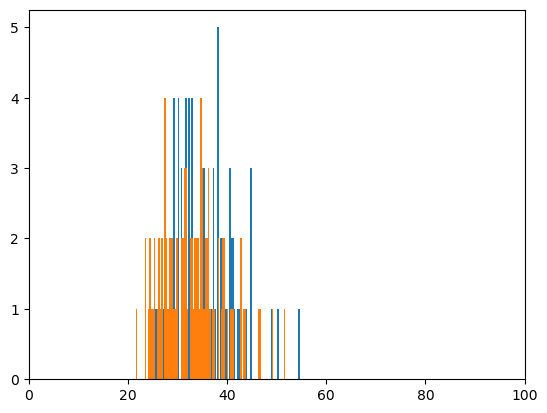

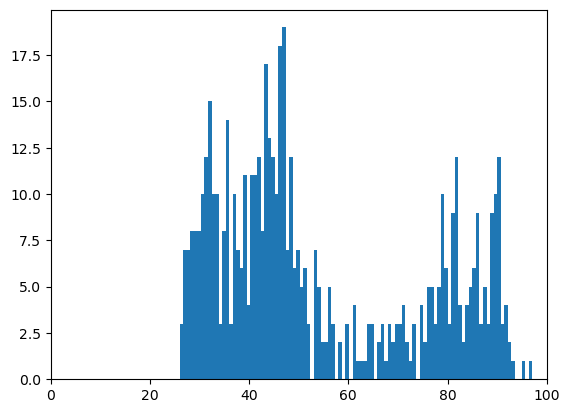

In [9]:
### Task 3
### YOUR CODE
tumors_dist = final_dist[test_labels_w_ood == 0]
stromas_dist = final_dist[test_labels_w_ood == 1]
OoD_dist = final_dist[test_labels_w_ood == -1]
plt.hist(tumors_dist, bins=100, alpha=1, label='Tumors')
plt.xlim((0,100))
plt.hist(stromas_dist, bins=100, alpha=1, label='Stromas')
plt.show()
plt.hist(OoD_dist, bins=100, alpha=1, label='OoD')
plt.xlim((0,100))
plt.show()


**Observations:**

**Task 4 (1 point)** Find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out?

In [10]:
### Task 4
### YOUR CODE
sorted_dist = np.sort(final_dist)
threshold = sorted_dist[int(0.05*len(sorted_dist))]
print(threshold)
# Number of tumor that will be filtered out :
nb_tumors_filtered = (tumors_dist > threshold).sum()
print(nb_tumors_filtered)

# Number of stroma that will be filtered out :
nb_stromas_filtered = (stromas_dist > threshold).sum()
print(nb_stromas_filtered)



27.627481
87
74


**Task 5 (0.5 point)** Assign prediction -1 to filtered out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```). Is it satisfactory?

In [11]:
### Task 5
### YOUR CODE
predictions[final_dist > threshold] = -1
accuracy = (predictions == test_labels_w_ood).sum()/len(test_labels_w_ood)
print(accuracy)

0.7661290322580645


### 1.3 Out-of-distribution detection with k-NN classifier (6 points)

The visual foundation models are known to be very good k-NN classifiers. It motivates us to implement a k-NN classifier to recognize TUMOR and STROMA. Moreover, k-NN distance is a good OoD-ness score and suits our task.

**Task 1 (2 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using a k-NN classifier. Then report the accuracy of your predictions with the test labels (```test_labels```).

*Note:* The choice of `k` is up to you.

In [12]:
### Task 1
### YOUR CODE
import sklearn
import sklearn.neighbors

# k-NN classifier to classify test_features:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(train_features, train_labels)
predictions = knn.predict(test_features)

accuracy = (predictions == test_labels).sum()/len(test_labels)
print(accuracy)


1.0


In [13]:
# Implementation of the Knn classifier without using sklearn :
def knn_classifier(train_features, train_labels, test_features, k):
    predictions = []
    for test_feature in test_features:
        distances = np.linalg.norm(train_features - test_feature, axis=1)
        sorted_indices = np.argsort(distances)
        k_nearest_labels = train_labels[sorted_indices[:k]]
        predictions.append(np.argmax(np.bincount(k_nearest_labels)))
    return np.array(predictions)

predictions = knn_classifier(train_features, train_labels, test_features, 10)
accuracy = (predictions == test_labels).sum()/len(test_labels)
print(accuracy)

1.0


**Task 2 (2 points)** Perform OoD detection on the test features (```test_features_w_ood```) using a k-NN distance based OoD-ness score. Find a threshold on your OoD-ness score such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out? Finally, assign prediction -1 to filter out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```).

*Note:* The OoD-ness is based on the distance to the k-nearest neighbors. The formulation is up to you. You have to justify your choice.

In [14]:
### Task 2
### YOUR CODE

# k-NN distance based OoD-ness score :
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(train_features, train_labels)
predictions = knn_classifier(train_features, train_labels, test_features_w_ood, 10)
final_dist = knn.kneighbors(test_features_w_ood, return_distance=True)[0][:, -1]
sorted_dist = np.sort(final_dist)
threshold = sorted_dist[int(0.05*len(sorted_dist))]
print(threshold)

predictions[final_dist > threshold] = -1
accuracy = (predictions == test_labels_w_ood).sum()/len(test_labels_w_ood)
print(accuracy)

# The accuracy obtained with k-NN is higher than the one obtained with the Mahalanobis distance. 
# This can be explained by the fact that 





44.06264406004819
0.7956989247311828


**Task 3 (1 point)** Is k-NN better than Mahalanobis distance ? Make an hypothesis for the reasons.

**Answer:**
The accuracy obtained with k-NN is higher than the one obtained with the Mahalanobis distance. This can be explained by multiple factors:

Data Nature: Mahalanobis distance assumes Gaussian distribution, which may not be suitable for the data.

Feature Space: k-NN is more flexible in capturing complex patterns compared to the Mahalanobis distance.

Class Imbalance: k-NN can handle class imbalance better than the Mahalanobis distance.

Robustness to Outliers: k-NN is more robust to outliers compared to the Mahalanobis distance.

Flexibility and Adaptability: k-NN can adapt to different tasks by adjusting the value of k, unlike the fixed Mahalanobis distance.

**Task 4 (1 point)** Do you think we can suggest the approach presented in this exercise to compute TUMOR/STROMA ratio automatically ? Justify your thoughs. If not, suggest at least two ideas to improve it.

*Note:* Annotating all the training dataset is not an option.

**Answer:** Suggested Approach for TUMOR/STROMA Ratio Computation:

Incomplete Labeling: The proposed approach only focuses on labeling the tissues of interest (TUMOR and STROMA) while ignoring the other tissue types. However, the TUMOR/STROMA ratio calculation requires knowledge of all tissue types present in the histology image. Without complete labeling, it would be challenging to accurately compute the ratio.

Limited Information: The binary classifier trained using the proposed approach can only identify TUMOR and STROMA tissues, but it may not provide sufficient information for computing the ratio. The ratio calculation typically involves considering the area or proportion of different tissue types in the histology image, which requires more detailed annotations beyond just binary classification.

Improvement Ideas:

Semi-Supervised Learning: Adopt a semi-supervised approach by incorporating fully labeled samples and leveraging unlabeled data for enhanced training.

Active Learning: Utilize active learning techniques to selectively query the annotator for labeling informative samples, improving the model with minimal annotation efforts.

---

## Part 2 (12 points)
In this part, we aim to classify cervical cells resulting from Pap smear tests. To that end we'll be using a publicly available cell dataset: Sipakmed (https://www.cs.uoi.gr/~marina/sipakmed.html). The dataset is composed of 4049 images of isolated cells cropped from 966 cluster cell images of Pap smear slides. Each cell in the dataset has been categorized in either of the following categories: 

    - Superficial-Intermediate.
    - Parabasal.
    - Koilocytotic.
    - Dysketarotic.
    - Metaplastic.
Your objective is to implement a classifier to automate the cell classification process. To ease your work we provide you with pre-computed embeddings for each images (`lab-03-data/part2/sipakmed_clean_embeddings.pth`). The embeddings are obtained from a pre-trained ResNet-50 (https://arxiv.org/pdf/1512.03385.pdf) and the corresponding images are also provided (`lab-03-data/part2/sipakmed_clean`). Note that you are free to discard the provided embeddings and work directy with the images.

### 2.1 Dataset (4 points)
Your first task is prepare the dataset such that it can be used to train your model. For that purpose we prepared the skeleton of the class `Sipakmed` that inherits from the class `Dataset` of PyTorch. Read the documentation (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) and complete the missing parts.

In [15]:
import torch
import sklearn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [16]:
# Load the features
features_path = '../data/lab-03-data/part2/sipakmed_clean_embeddings.pth'

In [17]:
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }
    
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
        
    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.features)

    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of the queried index.
        """
        embedding = self.features[index]
        label = self.labels[index]
        path = self.paths[index]
        return embedding, label, path

Once the implementation of `Sipakmed` completed, create 3 instances of the class (train/val/test) with the corresponding `phase` flag.

In [18]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path, phase="train")
val_dataset = Sipakmed(features_path, phase="val")
test_dataset = Sipakmed(features_path, phase="test")

Now that your datasets are ready, use the class `DataLoader` from PyTorch to let it handle efficiently the batching, shuffling, etc. of your data.

In [19]:
# Instantiate the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Get to know your data. Plot a few example images for each class of your dataset.

../data/lab-03-data/part2/sipakmed_clean/im_Superficial-Intermediate/032_09.jpg
../data/lab-03-data/part2/sipakmed_clean/im_Parabasal/020_03.jpg
../data/lab-03-data/part2/sipakmed_clean/im_Metaplastic/073_01.jpg
../data/lab-03-data/part2/sipakmed_clean/im_Koilocytotic/043_03.jpg
../data/lab-03-data/part2/sipakmed_clean/im_Dyskeratotic/099_03.jpg


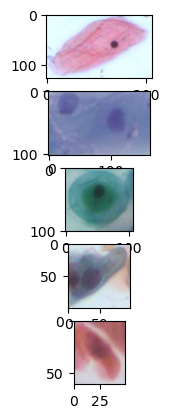

In [20]:
# Visualize some training example
### YOUR CODE

folder_path='../data/lab-03-data/part2/'
fig, ax=plt.subplots(5)
i=0
for item in train_loader:
    # Perform your training or evaluation on the batched data
    embeddings, labels, paths= item
    unique_labels = np.unique(labels)  # Get unique class labels

    # Plot one embedding for each class
    list_embeddings=[]
    list_paths=[]
    for label in unique_labels:
        # Find the first embedding corresponding to the current label
        index = np.where(labels == label)[0][0]
        embedding = embeddings[index]
        path=folder_path+paths[index]
        list_embeddings.append(embedding)
        list_paths.append(path)

for i in range(len(list_paths)):
    print(list_paths[i])
    img=plt.imread(list_paths[i])
    ax[i].imshow(img)


### 2.2 Training (4 points)
In this part your objective is to implement the required tools to train your model. The first thing you'll need is a a model which takes as input the pre-computed features and returns the corresponding class probabilities/logits.

In [21]:
# Implement the model
embedding_dim = train_dataset.features.shape[1]
model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(embedding_dim, 128)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(128, 64)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(64, 5)),
    ('softmax', nn.Softmax(dim=1))
]))



The optimizer will keep track of your model's parameters, gradients, etc (https://pytorch.org/docs/stable/optim.html). It is responsible to update your model's parameters after each forward pass using the backpropagation algorithm.

In [22]:
# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Set the loss
criterion = nn.CrossEntropyLoss()

Implement a function that takes as input the model's output and the corresponding labels and returns the perçentage of correct predictions.

In [24]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    # Get the predicted classes
    _, predicted = torch.max(outputs, 1)
    # Count the number of correct predictions
    correct = (predicted == labels).sum().item()
    # Compute the accuracy
    accuracy = correct / labels.size(0)
    return accuracy

Implement a funtion `train` that forwards the complete training set through your model (= 1 epoch) and updates its parameters after each forward pass. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [55]:
def train(model, optimizer, criterion, loader):
    # Set the model in train mode
    ### YOUR CODE
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths 

        embeddings, labels, paths = batch 

        # Feed the embeddings to the model
        outputs = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(outputs, labels)
        # Reset the gradients
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Store the outputs and labels for later use
        full_outputs.append(outputs)
        full_labels.append(labels)

        # Store the loss
        losses.append(loss.item())

    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    print(losses)
    losses = torch.tensor(losses).mean().cpu()

    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses

Implement a funtion `validate` that forwards the complete validation or test set through your model and evaluates its predictions. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [56]:
@torch.no_grad()
def validate(model, criterion, loader):
    # Set the model in train mode
    ### YOUR CODE
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths
        embeddings, labels, paths = batch
        
        # Feed the embeddings to the model
        outputs = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(outputs, labels)
        
        # Store the outputs, labels and loss
        full_outputs.append(outputs)
        full_labels.append(labels)
        full_paths.append(paths)
        losses.append(loss.item())

    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    # If you get the error TypeError: expected Tensor as element 0 in argument 0, but got float
    # it means that you are using a version of PyTorch that does not support the method .mean() on tensors
    losses = torch.tensor(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)
    
    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses, full_paths

You should now be able to train you model. Alternate between training and validation steps to find and save the best model (best accuracy on the validation set).

In [62]:
with open("test.txt", "w") as f:
    f.write("Hello World")

In [61]:
# Main loop
epochs = 10
best_acc = 0
model_savepath = '../data/model.pth'

for epoch in range(epochs):
    # Train
    train_acc, train_outputs, train_labels, train_losses = train(model, optimizer, criterion, train_loader)

    # Evaluate
    val_acc, val_outputs, val_labels, val_losses, val_paths = validate(model, criterion, val_loader)
    
    # Save the model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_savepath)

[0.9381592869758606, 0.9142858386039734, 0.905174732208252, 0.9074780941009521, 0.9374234080314636, 0.9157957434654236, 0.9050623774528503, 0.9370157122612, 0.9052833318710327, 0.9049452543258667, 0.9122827649116516, 0.9053784608840942, 0.9051244258880615, 0.9049853086471558, 0.9074769616127014, 0.9051607251167297, 0.913137674331665, 0.9051435589790344, 0.9591003656387329, 0.92060786485672, 0.9056185483932495, 0.905125081539154, 0.9050227999687195, 0.9354755878448486, 0.9076423048973083, 0.939789891242981, 0.9112663865089417, 0.9050776362419128, 0.9159230589866638, 0.9149796962738037, 0.9059516191482544, 0.9059430956840515, 0.9059934616088867, 0.9052473306655884, 0.9059522747993469, 0.9053145051002502, 0.9133079648017883, 0.906326949596405, 0.9367095232009888, 0.9103716611862183, 0.9049229621887207, 0.936370313167572, 0.9285168647766113, 0.9307267069816589, 0.9055263996124268, 0.908856213092804, 0.9085519313812256, 0.9053342342376709, 0.9052391648292542, 0.915213406085968, 0.9362068772

PermissionError: [Errno 13] Permission denied: '../../'

### 2.3 Evaluation (4 points)
Re-load the best model and evaluate its predictions on the test set.

In [ ]:
# Re-load the best model
model.load_state_dict(torch.load(model_savepath))

# Evaluate
test_acc, test_outputs, test_labels, test_losses, test_paths = validate(model, criterion, test_loader)

A useful tool to analyze your model's performance on the different classes is the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Computes its entries for your model and the test set.

In [ ]:
# Display the confusion matrix
confusion_matrix = confusion_matrix(test_labels, test_outputs.argmax(1))

Alternatively it can be useful to plot the problematic samples as well as the predicted and ground truth classes. Can you do so?

In [ ]:
# Find the misclassified samples
misclassified_samples = np.where(test_labels != test_outputs.argmax(1))[0]

# Plot the misclassified samples
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        index = misclassified_samples[i * 5 + j]
        path = test_paths[index]
        img = plt.imread(path)
        ax[i, j].imshow(img)
        ax[i, j].set_title(f'Predicted: {test_outputs[index].argmax(0)}\nTrue: {test_labels[index]}')
        ax[i, j].axis('off')
